In [9]:

import os
from typing import Optional
import cv2 as cv
import numpy as np
import matplotlib.pyplot as plt
from typing import Tuple
from typing import Any
Image = np.ndarray

In [10]:
def preprocess_image(image: Image) -> Image:
    """
    Preprocesses an image by removing the hand first, then deskewing, and removing noise.

    Args:
        image (Image): Input image.

    Returns:
         Preprocessed and aligned image.
    """
    img = image.copy()

    # Step 1: Remove the hand if present (only if the input is BGR)
    if len(image.shape) == 3:  # Check if the image is in color
        # Convert to HSV and define skin detection thresholds
        hsv = cv.cvtColor(img, cv.COLOR_BGR2HSV)
        lower_skin1 = np.array([0, 20, 50], dtype=np.uint8)
        upper_skin1 = np.array([25, 170, 255], dtype=np.uint8)
        lower_skin2 = np.array([160, 20, 50], dtype=np.uint8)
        upper_skin2 = np.array([180, 170, 255], dtype=np.uint8)

        # Create skin masks and combine them
        mask1 = cv.inRange(hsv, lower_skin1, upper_skin1)
        mask2 = cv.inRange(hsv, lower_skin2, upper_skin2)
        skin_mask = cv.bitwise_or(mask1, mask2)

        # Check if significant skin regions are detected
        if cv.countNonZero(skin_mask) > 1000:
            # Refine the skin mask with morphological operations
            kernel = cv.getStructuringElement(cv.MORPH_ELLIPSE, (5, 5))
            skin_mask = cv.morphologyEx(skin_mask, cv.MORPH_CLOSE, kernel, iterations=2)
            skin_mask = cv.morphologyEx(skin_mask, cv.MORPH_OPEN, kernel, iterations=2)

            # Find the largest skin contour
            contours, _ = cv.findContours(skin_mask, cv.RETR_EXTERNAL, cv.CHAIN_APPROX_SIMPLE)
            if contours:
                largest_contour = max(contours, key=cv.contourArea)

                # Create a filled mask for the hand region
                hand_mask = np.zeros_like(skin_mask)
                cv.drawContours(hand_mask, [largest_contour], -1, 255, thickness=cv.FILLED)

                # Inpaint to remove the hand
                img = cv.inpaint(img, hand_mask, inpaintRadius=3, flags=cv.INPAINT_TELEA)

    # Step 2: Convert to grayscale if needed
    if len(img.shape) == 3:
        img_gray = cv.cvtColor(img, cv.COLOR_BGR2GRAY)
    else:
        img_gray = img

    # Step 3: Thresholding
    _, thresholded = cv.threshold(img_gray, 128, 255, cv.THRESH_BINARY_INV)

    # Step 4: Morphological operations to close gaps
    kernel = cv.getStructuringElement(cv.MORPH_RECT, (9, 9))
    thresholded = cv.morphologyEx(thresholded, cv.MORPH_CLOSE, kernel)

    # Step 5: Find contours and deskew the image if needed
    contours, _ = cv.findContours(thresholded, cv.RETR_EXTERNAL, cv.CHAIN_APPROX_SIMPLE)
    if contours:
        largest_contour = max(contours, key=cv.contourArea)
        rect = cv.minAreaRect(largest_contour)
        angle = rect[-1]
        (h, w) = img.shape[:2]
        center = (w // 2, h // 2)
        rotation_matrix = cv.getRotationMatrix2D(center, angle - 90 , 1.0)
        print(angle)
        img_gray = cv.warpAffine(img_gray, rotation_matrix, (w, h), flags=cv.INTER_CUBIC, borderMode=cv.BORDER_REPLICATE)

    # Step 6: Apply blurring and denoising
    img_blurred = cv.medianBlur(cv.blur(img_gray, (3, 3)), 3)
    _, img_denoised = cv.threshold(img_blurred, 0, 255, cv.THRESH_BINARY + cv.THRESH_OTSU)

    # Step 7: Morphological closing to clean up
    closing_kernel = cv.getStructuringElement(cv.MORPH_RECT, (1, 7))
    img_denoised = cv.morphologyEx(img_denoised, cv.MORPH_CLOSE, closing_kernel, iterations=2)

    # Step 8: remove sine wave noise
    kernel = cv.getStructuringElement(cv.MORPH_RECT, (50, 1))
    img_dilated = cv.morphologyEx(img_denoised, cv.MORPH_DILATE, kernel)
    if len(np.unique(img_dilated)) > 1:
        img_denoised = cv.adaptiveThreshold(
            img_gray, 255, cv.ADAPTIVE_THRESH_GAUSSIAN_C, cv.THRESH_BINARY, 11, 2
        )
    return img_denoised

In [11]:
def crop_barcode(img: Image) -> Image:
    """
    Crops the barcode region from the image

    Args:
        image (Image): Input image.

    Returns:
        Cropped barcode image
    """
    # Step 1: Convert to grayscale if needed
    if len(img.shape) == 3:
        img = cv.cvtColor(img, cv.COLOR_BGR2GRAY)

    # Step 2: Thresholding

    _, thresholded = cv.threshold(img, 128, 255, cv.THRESH_BINARY_INV)

    # Step 3: Morphological Closing
    kernel = cv.getStructuringElement(cv.MORPH_RECT, (9, 9))
    thresholded = cv.morphologyEx(thresholded, cv.MORPH_CLOSE, kernel)

    # Step 4: Find contours
    contours, _ = cv.findContours(thresholded, cv.RETR_EXTERNAL, cv.CHAIN_APPROX_SIMPLE)
    # Step 5: Find the largest contour (assumed to be the barcode)
    largest_contour = max(contours, key=cv.contourArea)

    # Step 6: Use minAreaRect to find orientation and bounding box
    rect = cv.minAreaRect(largest_contour)
    angle = rect[-1]

    # Adjust the angle to the correct range for deskewing
    if angle < -45:
        angle += 90

    # Rotate the image to deskew the barcode only if necessary
    if abs(angle - 90) > 1 and abs(angle) > 1:  # Check if rotation is necessary
        (h, w) = img.shape
        center = (w // 2, h // 2)
        rotation_matrix = cv.getRotationMatrix2D(center, angle - 90, 1.0)
        rotated_img = cv.warpAffine(img, rotation_matrix, (w, h), flags=cv.INTER_CUBIC, borderMode=cv.BORDER_REPLICATE)
        thresholded_rotated = cv.warpAffine(thresholded, rotation_matrix, (w, h))  # Rotate thresholded image
    else:
        rotated_img = img  # No rotation needed
        thresholded_rotated = thresholded  # Use original thresholded image

    # Step 8: Extract the barcode region after rotation
    contours, _ = cv.findContours(thresholded_rotated, cv.RETR_EXTERNAL, cv.CHAIN_APPROX_SIMPLE)
    largest_contour = max(contours, key=cv.contourArea)
    rect = cv.minAreaRect(largest_contour)
    box = cv.boxPoints(rect)
    box = np.intp(box)

    # Create a bounding box to crop the barcode
    x_min, x_max = min(box[:, 0]), max(box[:, 0])
    y_min, y_max = min(box[:, 1]), max(box[:, 1])

    # Add the margin to the horizontal boundaries
    x_min = max(0, x_min - 5)  # Ensure x_min is not negative
    x_max = min(rotated_img.shape[1], x_max + 5)  # Ensure x_max does not exceed image width

    cropped_img = rotated_img[y_min:y_max, x_min:x_max]

    # Repair barcode by doing vertical erosion and dilation

    kernel = cv.getStructuringElement(cv.MORPH_RECT, (1, 80))
    eroded = cv.erode(cropped_img, kernel, iterations=1)

    kernel2 = cv.getStructuringElement(cv.MORPH_RECT, (1, 20))
    dilated = cv.dilate(eroded, kernel2, iterations=2)


    kernel3 = cv.getStructuringElement(cv.MORPH_RECT, (1, 60))
    dilated2 = cv.dilate(dilated, kernel3, iterations=3)

    return dilated2


90.0


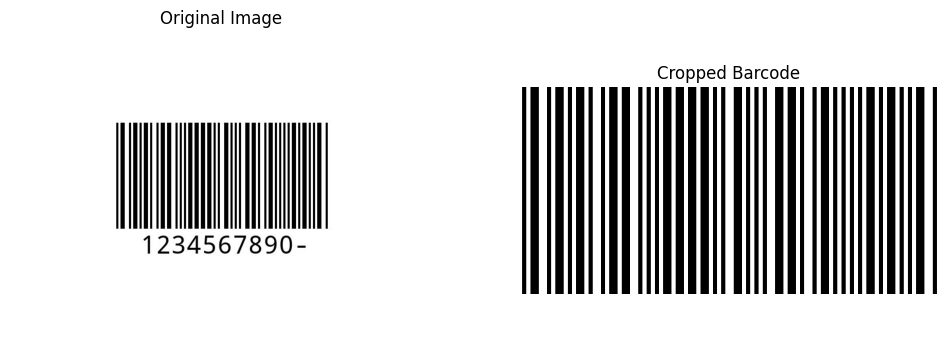

90.0


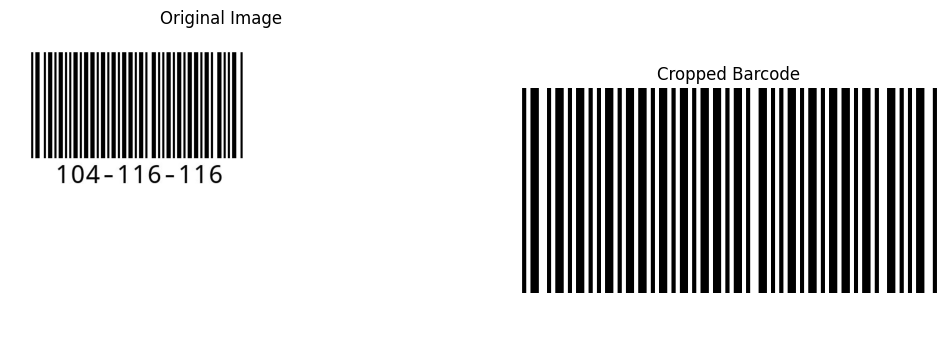

90.0


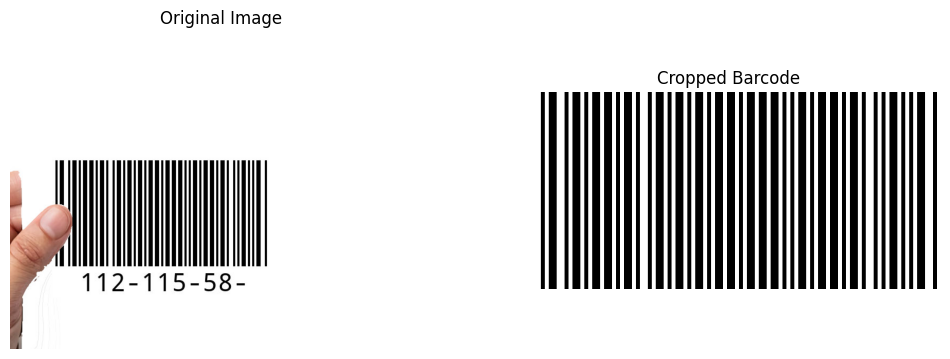

90.0


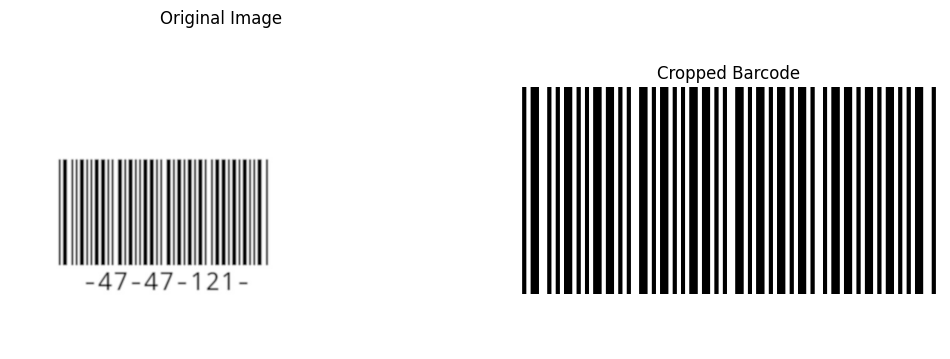

90.0


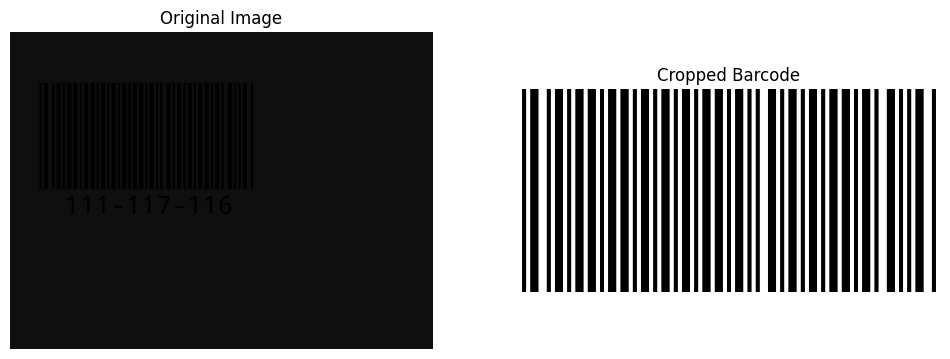

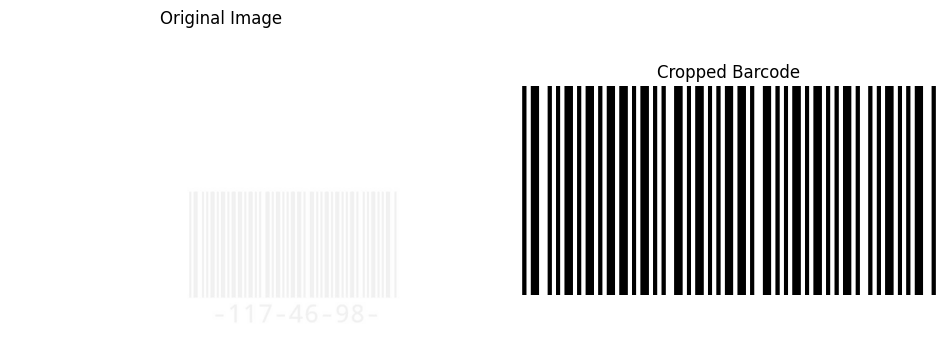

90.0


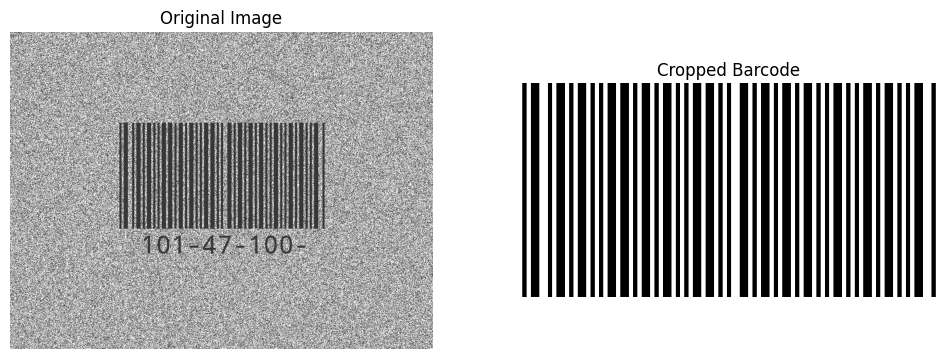

90.0


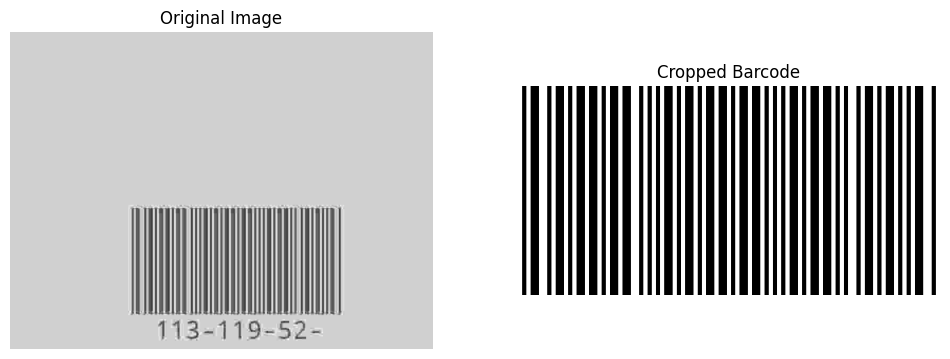

61.821407318115234


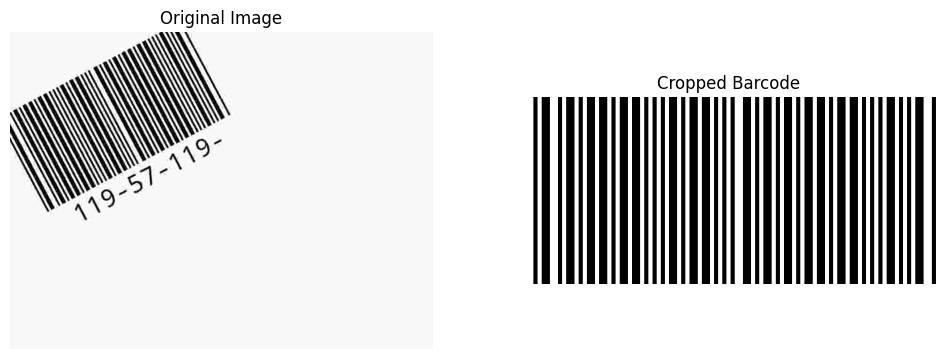

90.0


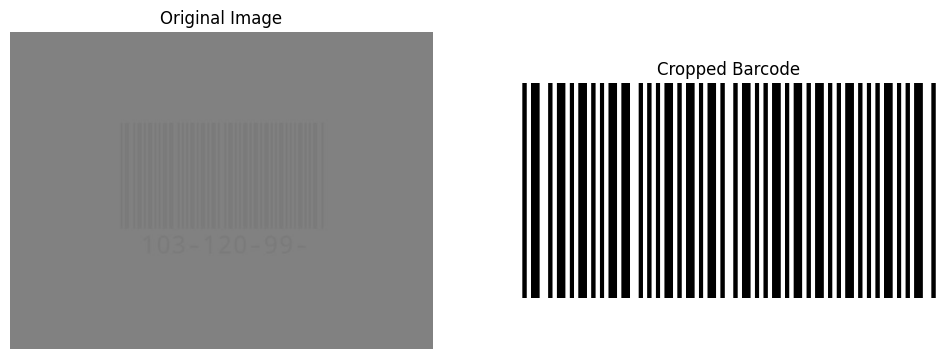

90.0


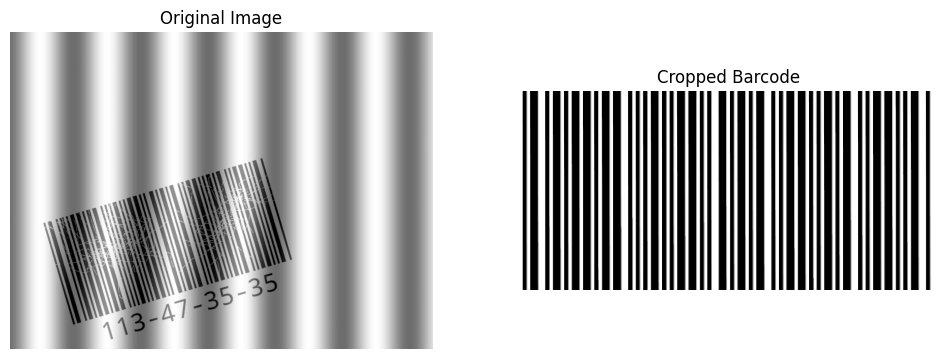

In [12]:
def display_before_after(original_img: Image, cropped_img: Image, title_before: str = "Original Image", title_after: str = "Cropped Barcode"):
    plt.figure(figsize=(12, 6))
    images = [(original_img, title_before), (cropped_img, title_after)]
    for i, (img, title) in enumerate(images):
        plt.subplot(1, 2, i + 1)
        plt.imshow(img if len(img.shape) == 2 else cv.cvtColor(img, cv.COLOR_BGR2RGB), cmap='gray' if len(img.shape) == 2 else None)
        plt.title(title)
        plt.axis("off")
    plt.show()

def process_test_cases(image_folder: str):
    files = [f for f in os.listdir(image_folder) if f.endswith(".jpg")]
    files.sort(key=lambda x: int(os.path.splitext(x)[0].split()[0]))
    output_folder = os.path.join(image_folder, "Processed_Output")
    os.makedirs(output_folder, exist_ok=True)

    for i, file_name in enumerate(files):
        image_path = os.path.join(image_folder, file_name)
        original_img = cv.imread(image_path)
        if original_img is None:
            print(f"Could not read image {file_name}. Skipping...")
            continue

        cleaned_img = preprocess_image(original_img)
        cropped_img = crop_barcode(cleaned_img)


        cv.imwrite(os.path.join(output_folder, f"Cropped_{file_name}"), cropped_img)
        display_before_after(original_img, cropped_img)

if __name__ == "__main__":
    folder = r"C:\Users\A\Desktop\CV-main\Test Cases-20241123"
    process_test_cases(folder)

In [13]:

def decoder(your_cropped_image):

    # 0 means narrow, 1 means wide
    NARROW = "0"
    WIDE = "1"
    code11_widths = {
        "00110": "Stop/Start",
        "10001": "1",
        "01001": "2",
        "11000": "3",
        "00101": "4",
        "10100": "5",
        "01100": "6",
        "00011": "7",
        "10010": "8",
        "10000": "9",
        "00001": "0",
        "00100": "-",
    }

    # Get the average of each column in your image
    mean = your_cropped_image.mean(axis=0)

    # Set it to black or white based on its value
    mean[mean <= 127] = 1  # Black
    mean[mean > 128] = 0   # White

    # Convert to string of pixels in order to loop over it
    pixels = ''.join(mean.astype(np.uint8).astype(str))

    # Find the first black pixel
    first_black_index = pixels.find('1')
    if first_black_index == -1:
        return []  # No barcode found

    # Start decoding from the first black pixel
    pixels = pixels[first_black_index:]

    # Determine the size of a narrow bar
    narrow_bar_size = 0
    for pixel in pixels:
        if pixel == "1":
            narrow_bar_size += 1
        else:
            break

    wide_bar_size = narrow_bar_size * 2

    # Define tolerance for narrow and wide bar sizes
    tolerance_factor = 0.1  # 10% tolerance
    narrow_min = narrow_bar_size * (1 - tolerance_factor)
    narrow_max = narrow_bar_size * (1 + tolerance_factor)
    wide_min = wide_bar_size * (1 - tolerance_factor)
    wide_max = wide_bar_size * (1 + tolerance_factor)

    digits = []
    pixel_index = 0
    current_digit_widths = ""
    skip_next = False

    while pixel_index < len(pixels):

        if skip_next:
            pixel_index += narrow_bar_size
            skip_next = False
            continue

        count = 1
        try:
            while pixels[pixel_index] == pixels[pixel_index + 1]:
                count += 1
                pixel_index += 1
        except IndexError:
            pass
        pixel_index += 1

        # Use tolerance to classify as narrow or wide
        if narrow_min <= count <= narrow_max:
            current_digit_widths += NARROW
        elif wide_min <= count <= wide_max:
            current_digit_widths += WIDE
        else:
            # Unrecognized width, possibly noise, skip this segment
            current_digit_widths = ""
            continue

        if current_digit_widths in code11_widths:
            digits.append(code11_widths[current_digit_widths])
            current_digit_widths = ""
            skip_next = True  # Next iteration will be a separator, so skip it

    return digits


cropped_image_path_Folder = "C:\\Users\\A\\Desktop\\CV-main\\Test Cases-20241123\\Processed_Output"

# Get a sorted list of image files
cropped_images = sorted(os.listdir(cropped_image_path_Folder))

for cropped_image in cropped_images:
    cropped_image_path = os.path.join(cropped_image_path_Folder, cropped_image)
    cropped_img = cv.imread(cropped_image_path, cv.IMREAD_GRAYSCALE)
    if cropped_img is not None:
        decoded_digits = decoder(cropped_img)
        print("Decoded barcode:", ''.join(decoded_digits))


Decoded barcode: Stop/Start1234567890-Stop/Start
Decoded barcode: Stop/Start104-116-116Stop/Start
Decoded barcode: Stop/Start112-115-58-Stop/Start
Decoded barcode: Stop/Start-47-47-121-Stop/Start
Decoded barcode: Stop/Start111-117-116Stop/Start
Decoded barcode: Stop/Start-117-46-98-Stop/Start
Decoded barcode: Stop/Start101-47-100-Stop/Start
Decoded barcode: Stop/Start113-119-52-Stop/Start
Decoded barcode: Stop/Start119-57-119-Stop/Start
Decoded barcode: Stop/Start103-120-99-Stop/Start
Decoded barcode: Stop/Start11347-35-35Stop/Start
